#### Importing Libraries

In [270]:
import pandas as pd
import numpy as np

from hmmlearn.hmm import GaussianHMM
from pandas_datareader.data import DataReader
import yfinance as yf
import matplotlib.pyplot as plt

#### Data Extraction

Extracting historical data for the specified cryptocurrency, 'BTC-USD', from Yahoo Finance using `yfinance`. The data range is set


In [271]:
start_date = '2021-01-01'
end_date = '2023-12-31'
symbol = 'BTC-USD'
data = yf.download(symbol, start_date, end_date)
data = data[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Adj Close,Volume
Date,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,40730301359
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,67865420765
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,78665235202
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,81163475344
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,67547324782


### Adding Returns and Range to the Data

In this section, a copy of the original data is created for further manipulation. Two new columns are added:

- `Returns`: Calculated as the percentage change in the Adjusted Close price from the previous day. It's a common financial metric used to understand the asset's performance.
- `Range`: Represents the daily price range, calculated as the percentage difference between the High and Low prices of the day.

The data is then cleaned by removing any rows with missing values (`NaN`) using `dropna()`. Finally, the length of the dataframe and the first few rows are displayed for verification and initial analysis.


In [272]:
df = data.copy()
df['Returns'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
df['Range'] = (df['High'] / df['Low']) - 1
df.dropna(inplace = True)
print('len: ', len(df))
df.head()


len:  1093


,Open,High,Low,Adj Close,Volume,Returns,Range
Date,,,,,,,
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,67865420765,0.093726,0.139696
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,78665235202,0.020380,0.079752
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,81163475344,-0.024712,0.164241
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,67547324782,0.063197,0.139518
2021-01-06,34013.613281,36879.699219,33514.035156,36824.363281,75289433811,0.083311,0.100426


### Incorporating Moving Averages into the Dataset

This section focuses on adding moving average indicators to the dataframe:

- `MA-12`: This represents the 12-day moving average of the Adjusted Close prices. A moving average smooths out price data to create a single flowing line, making it easier to identify the direction of the trend.
- `MA-21`: Similarly, this is the 21-day moving average of the Adjusted Close prices.

The moving averages are computed using the `rolling()` function, which provides rolling window calculations. The `tail()` function is used to display the last few rows of the dataframe, showing the newly added moving averages for recent dates.


In [273]:
#Add moving average
df['MA-12'] = df['Adj Close'].rolling(window = 12).mean()
df['MA-21'] = df['Adj Close'].rolling(window = 21).mean()
df.tail()

,Open,High,Low,Adj Close,Volume,Returns,Range,MA-12,MA-21
Date,,,,,,,,,
2023-12-26,43599.847656,43603.175781,41676.488281,42520.402344,30026850982,-0.025055,0.046230,42903.092773,42959.870350
2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,25260941032,0.021694,0.035942,43029.184245,42945.413690
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,22992093014,-0.018760,0.035120,43061.495768,42913.756138
2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,26000021055,-0.012397,0.041045,43122.723958,42815.318080
2023-12-30,42091.753906,42584.125000,41556.226562,42156.902344,16013925945,0.001366,0.024735,43083.837565,42740.599888


### Structuring the Data for Training and Testing

In this part of the code, the dataset is split into training and testing sets for the purpose of model development and evaluation:

- `X_train`: The training set, consisting of the 'Returns' and 'Range' columns, includes the first 700 data points. This set will be used to train the machine learning model.
- `X_test`: The testing set, also containing 'Returns' and 'Range', consists of the remaining data points following the first 700. This set is used to evaluate the performance of the trained model.
- `save_df`: A separate dataframe saved from the 700th data point onward, possibly for further analysis or reference.

The code also prints the lengths of the training and testing datasets, as well as the date ranges they cover, to ensure the data is correctly partitioned and to provide clarity on the training and testing periods.


In [274]:
#Strucrute Data
X_train = df[['Returns', 'Range']].iloc[:700]
X_test = df[['Returns', 'Range']].iloc[700:]
save_df = df.iloc[700:]

print('Train len ', len(X_train))
print('Test len ', len(X_test))
print('X_train From ', X_train.head(1).index.item())
print('X_train to: ', X_train.tail(1).index.item())
print('X_test From ', X_test.head(1).index.item())
print('X_test to: ', X_test.tail(1).index.item())

Train len  700
Test len  393
X_train From  2021-01-02 00:00:00
X_train to:  2022-12-02 00:00:00
X_test From  2022-12-03 00:00:00
X_test to:  2023-12-30 00:00:00


### Training the Hidden Markov Model

This section is dedicated to training a Gaussian Hidden Markov Model (HMM) on the structured data:

- The model is instantiated with `n_components=4`, indicating that it will identify and use four hidden states. The `covariance_type='full'` suggests that each state can have its own general covariance matrix, allowing for more flexibility in the model.
- `model.fit(X_train.values)`: The HMM is trained using the `X_train` data, which consists of the 'Returns' and 'Range' features.
- After training, the model's `predict` method is used on the same training data to obtain the sequence of hidden states.
- The first 10 predicted states are printed out for an initial examination. These states represent the model's understanding of the underlying financial data's hidden processes.


In [275]:
model = GaussianHMM(n_components=4, covariance_type='full')
model.fit(X_train.values)
p = model.predict(X_train.values)
print(p[:10])

[1 1 1 1 1 1 1 1 1 1]


### Making Predictions on Test Data with HMM

In this code section, the Gaussian Hidden Markov Model, which was previously trained, is now utilized to make predictions on the test dataset:

- `df_main`: A new DataFrame is created as a copy of `save_df`. This DataFrame will be used to store and analyze the prediction results.
- The columns `High` and `Low` are dropped from `df_main`, focusing the analysis on the remaining features.
- `hmm_result`: The trained HMM model is applied to the `X_test` data to predict the hidden states. This step translates the model's understanding of the underlying financial processes to the unseen test data.
- The predicted states (`hmm_result`) are added to `df_main` in a new column named 'HMM'.
- The first few rows of `df_main` are displayed with the `.head()` method to show the initial results, including the new HMM predictions alongside the existing financial data.


In [276]:
#Make prediction in Test Date
df_main = save_df.copy()
df_main.drop(columns = ['High', 'Low'], inplace = True)

hmm_result = model.predict(X_test.values)
df_main['HMM'] = hmm_result
df_main.head()

,Open,Adj Close,Volume,Returns,Range,MA-12,MA-21,HMM
Date,,,,,,,,
2022-12-03,17090.097656,16908.236328,16217776704,-0.010558,0.013495,16635.882650,16587.246047,3
2022-12-04,16908.169922,17130.486328,16824520830,0.013144,0.015046,16714.275716,16624.251814,0
2022-12-05,17128.894531,16974.826172,22209086834,-0.009087,0.026930,16744.618978,16641.234049,2
2022-12-06,16975.238281,17089.503906,19889922369,0.006756,0.008969,16785.038900,16650.990746,3
2022-12-07,17089.505859,16848.126953,19675404389,-0.014124,0.021421,16812.229329,16659.499674,0


### Adding Moving Average (MA) Trading Signals

This portion of the code is focused on generating trading signals based on the Moving Average (MA) indicators:

- The code creates a new column, `MA_Signal`, in the `df_main` DataFrame.
- A trading signal is generated based on the comparison of two moving averages: `MA-12` (12-day moving average) and `MA-21` (21-day moving average).
- When `MA-12` is greater than `MA-21`, it indicates an upward trend, and the `MA_Signal` is set to `1`, representing a potential 'buy' signal.
- Conversely, when `MA-12` is less than or equal to `MA-21`, it suggests a downward or stable trend, and the `MA_Signal` is set to `0`, representing a potential 'sell' or 'hold' signal.
- This approach is a common technique in technical analysis, where crossing moving averages indicate possible market entry or exit points.


In [277]:
#Add MA Signals
df_main.loc[df_main['MA-12'] > df_main['MA-21'], 'MA_Signal'] = 1
df_main.loc[df_main['MA-12']<=df_main['MA-21'], 'MA_Signal'] = 0

### Refining HMM-Based Trading Signals

This section of the code enhances the trading signal strategy using the Hidden Markov Model (HMM) output:

- `favorable_states`: The list of favorable states is updated to include only states `[1, 3]`. This change indicates a more selective approach, considering only specific HMM states as positive for trading.
- `hmm_values`: As before, this extracts the HMM-predicted states from the `df_main` DataFrame.
- A revised logic is applied to generate signals: A `1` (buy signal) is assigned if the HMM state is in `favorable_states` (either state 1 or 3); otherwise, a `0` (sell or hold signal) is assigned. This is implemented using a list comprehension.
- The `HMM_Signal` column in `df_main` is updated with these new binary signals. The presence of `1` indicates a favorable trading condition as identified by the HMM, while `0` suggests non-favorable conditions.
- This update reflects a more nuanced application of HMM in the trading strategy, focusing on specific states that are deemed more likely to be indicative of profitable trading opportunities.


In [278]:
#Add HMM Signals
favorable_states = [1,3]
hmm_values = df_main['HMM'].values
hmm_values = [1 if x in favorable_states else 0 for x in hmm_values]
df_main['HMM_Signal'] = hmm_values



### Establishing Combined Trading Signal and Calculating Returns

#### Creating a Combined Trading Signal
- A new column `Main_Signal` is initialized to zero in the `df_main` DataFrame.
- A combined signal is generated using both the MA (Moving Average) and HMM signals. If both `MA_Signal` and `HMM_Signal` are `1` (indicating positive signals from both), `Main_Signal` is set to `1`. This approach implies a trade will be executed only when both signals agree.
- The `Main_Signal` is then shifted by one period to align the trade execution with the next day's opening (considering the signal is based on the previous day's data).





In [279]:
# Add Combined Signal
df_main['Main_Signal'] = 0
df_main.loc[(df_main['MA_Signal'] == 1) & (df_main["HMM_Signal"] == 1), 'Main_Signal'] = 1
df_main['Main_Signal'] = df_main['Main_Signal'].shift(1)

#### Benchmark Returns Calculation
- `lrets_bench`: Calculates the log returns of the benchmark, which is typically the Adjusted Close price of the asset.
- `bench_prod`: Cumulative sum of the benchmark's log returns.
- `bench_prod_exp`: The exponential of the cumulative log returns, representing the total percentage return of the benchmark over the period.


In [280]:
#Benchmark Returns
df_main['lrets_bench'] = np.log(df_main['Adj Close'] / df_main['Adj Close'].shift(1))
df_main['bench_prod'] = df_main['lrets_bench'].cumsum()
df_main['bench_prod_exp'] = np.exp(df_main['bench_prod']) - 1


#### Strategy Returns Calculation
- `lrets_strat`: Calculates the log returns for the strategy, adjusted by the `Main_Signal`. This implies that returns are counted only on days when the signal suggests a trade.
- `lrets_prod`: Cumulative sum of the strategy's log returns.
- `strat_prod_exp`: Exponential of the cumulative log returns of the strategy, indicating the total percentage return of the strategy over the period.


In [281]:
#Strategy Returns
df_main['lrets_strat'] = np.log(df_main['Open'].shift(-1) / df_main['Open']) * df_main['Main_Signal']
df_main['lrets_prod'] = df_main['lrets_strat'].cumsum()
df_main['strat_prod_exp'] = np.exp(df_main['lrets_prod']) - 1


#### Data Cleanup and Review
- The DataFrame is cleaned to remove any NaN values that might have been introduced during the calculations.
- The first few rows of the updated `df_main` DataFrame are displayed to review the newly calculated columns and signals.

In [282]:
#Review Results Table
df_main.dropna(inplace=True)
df_main.head()

,Open,Adj Close,Volume,Returns,Range,MA-12,MA-21,HMM,MA_Signal,HMM_Signal,Main_Signal,lrets_bench,bench_prod,bench_prod_exp,lrets_strat,lrets_prod,strat_prod_exp
Date,,,,,,,,,,,,,,,,,
2022-12-04,16908.169922,17130.486328,16824520830,0.013144,0.015046,16714.275716,16624.251814,0,1.0,0,1.0,0.013059,0.013059,0.013144,0.012970,0.012970,0.013054
2022-12-05,17128.894531,16974.826172,22209086834,-0.009087,0.026930,16744.618978,16641.234049,2,1.0,0,0.0,-0.009128,0.003931,0.003938,-0.000000,0.012970,0.013054
2022-12-06,16975.238281,17089.503906,19889922369,0.006756,0.008969,16785.038900,16650.990746,3,1.0,1,0.0,0.006733,0.010664,0.010721,0.000000,0.012970,0.013054
2022-12-07,17089.505859,16848.126953,19675404389,-0.014124,0.021421,16812.229329,16659.499674,0,1.0,0,1.0,-0.014225,-0.003561,-0.003555,-0.014271,-0.001301,-0.001301
2022-12-08,16847.349609,17233.474609,20496603770,0.022872,0.028539,16876.328776,16685.497628,2,1.0,0,0.0,0.022614,0.019053,0.019235,0.000000,-0.001301,-0.001301


### Calculating Sharpe Ratio and Strategy Metrics

#### Sharpe Ratio Function
- A function `sharpe_ratio` is defined to calculate the Sharpe Ratio, a key metric used to evaluate the risk-adjusted return of an investment.
- The Sharpe Ratio is computed using the formula: \((\text{Mean Return} - \text{Risk-Free Rate}) / \text{Standard Deviation of Return}\).
- `N = 255` represents the number of trading days in a year.
- `NSQRT` is the square root of `N`, used to annualize the standard deviation.
- `rf` is the risk-free rate, set at 1%.
- The function calculates the mean and standard deviation of the provided returns series, annualizes them, and then computes the Sharpe Ratio, rounding it to two decimal places.




In [283]:
# Sharpe Ration Metric
def sharpe_ratio(returns_series):
    N = 255
    NSQRT = np.sqrt(N)
    rf = .01
    mean = returns_series.mean() * N
    sigma = returns_series.std() * NSQRT
    sharpe_ratio = round((mean - rf) / sigma, 2)
    return sharpe_ratio

#### Metrics Calculation
- `bench_rets` and `strat_rets`: These variables calculate the total percentage return for the benchmark and the strategy, respectively, by extracting the last value from the cumulative exponential returns columns (`bench_prod_exp` and `strat_prod_exp`).
- `bench_sharpe` and `strat_sharpe`: The Sharpe Ratios for the benchmark and the strategy are computed using the `sharpe_ratio` function. This provides a measure of how much excess return is being received for the extra volatility endured for holding a riskier asset, compared to a risk-free asset.

In [284]:
# Metrics
bench_rets = round(df_main['bench_prod_exp'].values[-1] * 100, 1)
strat_rets = round(df_main['strat_prod_exp'].values[-1] * 100, 1)

bench_sharpe = sharpe_ratio(df_main['lrets_bench'].values)
strat_sharpe = sharpe_ratio(df_main['lrets_strat'].values)

### Displaying Performance Metrics

This section of the code is dedicated to printing out the calculated metrics for both the benchmark and the trading strategy. It provides a quick summary of their performance:

- The total percentage returns for both the benchmark (`bench_rets`) and the strategy (`strat_rets`) are displayed. These values give an immediate sense of how well the benchmark and the strategy have performed in terms of raw returns.

- The Sharpe Ratios for both the benchmark (`bench_sharpe`) and the strategy (`strat_sharpe`) are also printed. These values are crucial for understanding the risk-adjusted returns of the benchmark and strategy, indicating how much excess return is obtained for the extra risk taken compared to a risk-free asset.

This output helps in making a comparative analysis between the benchmark's performance and the trading strategy's effectiveness.


In [285]:
#Print Metrics
print(f'Rerurns Benchmark: {bench_rets}%')
print(f'Rerurns Strategy: {strat_rets}%')
print('----- ----- ----- ----- -----')
print(f'Sharpe Benchmark: {bench_sharpe}')
print(f'Sharpe Strategy: {strat_sharpe}')

Rerurns Benchmark: 149.0%
Rerurns Strategy: 60.9%
----- ----- ----- ----- -----
Sharpe Benchmark: 1.65
Sharpe Strategy: 2.41


### Visualization of Cumulative Returns

This part of the code is focused on visualizing the cumulative returns of both the benchmark and the strategy:

- `fig = plt.figure(figsize=(18, 10))`: Creates a new figure with a specified size (18x10 inches) for the plot.
- `plt.plot(df_main['bench_prod_exp'])`: Plots the cumulative exponential returns of the benchmark over the entire period. This line graph will illustrate how the benchmark's value has changed over time.
- `plt.plot(df_main['strat_prod_exp'])`: Similarly, this line plots the cumulative exponential returns of the trading strategy. 

The resulting plot provides a clear visual comparison between the performance of the benchmark and the strategy, highlighting their growth trends over the same period. This visualization is crucial for assessing the effectiveness of the trading strategy in comparison to a standard benchmark.


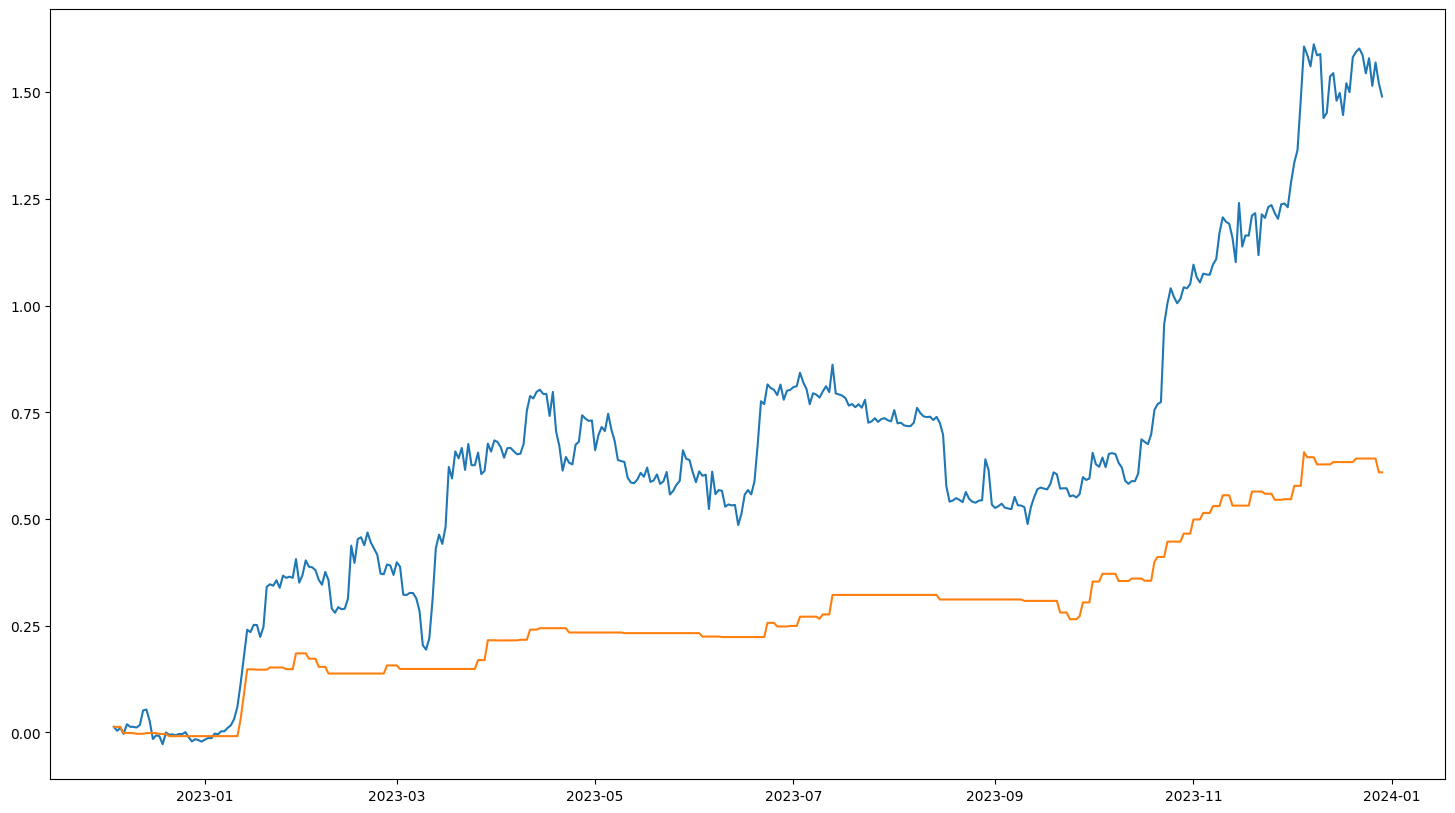

In [286]:
fig = plt.figure(figsize=(18, 10))
plt.plot(df_main['bench_prod_exp'])
plt.plot(df_main['strat_prod_exp'])